# Modules

In [79]:
import missingno  as msno
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Get data

In [80]:
import json
import pandas as pd
from sodapy import Socrata
from datetime import datetime,timedelta


class Get_Data():
    def __init__(self, df= pd.DataFrame()):
        self.df= df
    
    def create_df(self):
        
        client = Socrata("data.lacity.org", None)
        results = client.get("2nrs-mtv8", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd.csv')
        self.df = results_df
    
    
    def create_df_n_days(self,n):
        client = Socrata("data.lacity.org", None)
        # filtro para traer los ultimos n días
        date_filter = (datetime.utcnow() - timedelta(days=n)).strftime("%Y-%m-%dT%H:%M:%S.%f")
        results = client.get("2nrs-mtv8", where=f"date_rptd >= '{date_filter}'", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd_'+str(n)+'_days.csv')
        self.df = results_df       

        
    def infer_dtypes(self):
        ls_dates=["date_rptd", "date_occ"]
        ls_numeric=["vict_age","lat", "lon"]
        ls_strings=[x for x in self.df.columns if x not in ls_dates+ls_numeric]
        for date in ls_dates:
            self.df[date]= pd.to_datetime(self.df[date])
        for num in ls_numeric:
            self.df[num]= pd.to_numeric(self.df[num])
        for s in ls_strings:
            self.df[s].apply(lambda x: str(x).split(','))
        self.df["time_occ"]=self.df["time_occ"].apply(lambda x: int(x[0:2])*60+int(x[2:]))

In [81]:
data_loader= Get_Data()

In [82]:
data_loader.create_df()

In [83]:
data_loader.infer_dtypes()

In [84]:
df_all=data_loader.df

In [85]:
df=df_all.sort_values("date_rptd").reset_index()

In [86]:
df=df[df["date_rptd"]<="2023-02-27"].drop(columns=["index"])

In [132]:
df.to_csv("Train.csv", index=False)

In [87]:
data= df.copy()

## Cleaner

In [88]:
from pandas import DataFrame, read_excel, read_csv
from numpy import nan
import csv
import pickle


class ProductionCleaner():

    def __init__(self,data):
        self.df=data.copy()

        
    def manageNan(self):
        # fill nan's and typos
        #self.df.loc[self.df.vict_age==0,'vict_age']=nan
        #self.df.loc[(self.df.vict_age<0)|(self.df.vict_age>100),'vict_age']=nan
        self.df['weapon_used_cd'].fillna('0',inplace=True)
        #self.df["premis_cd"].fillna('746',inplace=True)
        self.df.loc[self.df.vict_sex.isna(),'vict_sex']='X'
        self.df.loc[self.df.vict_sex=='H','vict_sex']=='X'
        self.df.loc[self.df.vict_descent.isna(),'vict_descent']='U'
        self.df.loc[self.df.lon==0,['lat','lon']]=nan
    
    def dropColumns(self):
        # Drop columns
        self.df.drop(['crm_cd_1','crm_cd_2','crm_cd_3','crm_cd_4','area_name','time_occ',
                      'crm_cd_desc','premis_desc','weapon_desc', 'status_desc','area_name',
                      'date_occ','area','rpt_dist_no','part_1_2','mocodes', "vict_age"],axis=1,inplace=True)
        try:
            self.df.drop(self.df.loc[self.df.status=='CC'].index,inplace=True)
        except:
            pass
        
    def manageLocation(self):
        # Delete spaces
        self.df.location = self.df.location.str.strip()
        self.df.location = self.df.location.apply(lambda x: "  ".join(x.split()))
        self.df.location = self.df.location.str.replace(" ", "")
        self.df.location = self.df.location.str.upper()
        # Replace with dictonary values
        directorio = read_csv('Data/Cleaner/Directorio_Lat_Lon.csv')
        directorio.location = directorio.location.str.replace(" ", "")
        directorio.location = directorio.location.str.upper()
        loc_lat = dict(zip(directorio.location,directorio.lat))
        loc_lon = dict(zip(directorio.location,directorio.lon))
    
        # Verificar si las columnas "lat" o "lon" tienen valores faltantes
        mask = self.df['lat'].isna() | self.df['lon'].isna()
        # Verificar si los valores de la columna "location" están en las claves del diccionario "loc_lat"
        not_found = ~self.df.loc[mask, 'location'].isin(loc_lat.keys())
        self.df.loc[mask & ~not_found, 'lat'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lat)
        self.df.loc[mask & ~not_found, 'lon'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lon)
        ## Aqui duda, borramos los que no estan en el diccionario y son nulos o que sugieren?
        self.df.drop('location',axis=1,inplace=True)
        
    def clean(self):
        ## Esta funcion ya nos deja los datos sin nulos
        self.df.drop('cross_street',axis=1,inplace=True)
        self.manageNan()
        self.dropColumns()
        print(self.df.columns)
        self.manageLocation()
        
    
            
    def clipping(self):
        self.df['lon']=self.df['lon'].clip(-118.7, -118.1)
        self.df['lat']=self.df['lat'].clip(33.6, 34.4)
        
    def lugar(self):
        pl=[[[119,120,121,145,146.0,150.0,501.0, 502.0, 504.0,507.0, 508.0, 509.0, 510.0,511,515.0, 516.0,707],['vivienda']],
            [[101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 109.0, 110.0,116,117,
              124.0, 125.0,128,136.0, 137.0,152,154,158,415,705.0,748.0],['calle']],
            [[725.0, 726.0,240.0,732.0,752,753,756.0],['gobierno']],
            [[123,142,156,204.0, 213.0],['estacionamiento']],
            [[151.0,157.0,238,241,254,302,303,304.0, 305.0,702],['establecimiento']],
            [[201.0, 202.0, 203.0,205.0, 206.0,208,209.0, 210.0, 211.0,217.0, 218.0,
                                219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0,228,233.0,242,244.0, 245.0,
                                247.0, 248.0, 249.0,250.0, 251.0, 252.0,255,401.0, 402.0, 404.0, 405.0,
                                406.0, 407.0, 408.0,409.0, 410.0, 411.0, 412.0, 413.0, 414.0,417.0,703,
                                148.0,709,301,216
                                ],['establecimiento_publico']],
            [[207,706.0,733.0,735.0],['nocturno']],
            [[503,505,519.0],['hotel']],
            [[111.0, 112.0, 113.0, 114.0, 115.0,122,126,212.0, 214.0, 215.0,801.0, 802.0,804,809.0, 810.0,
                 811.0, 834.0, 835.0, 836.0, 868.0, 869.0, 870.0, 871.0, 872.0, 873.0,
                 874.0, 875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 882.0, 883.0, 884.0,
                                885.0, 889.0, 890.0, 891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897.0,
                                898.0, 900.0, 901.0, 902.0, 903.0, 904.0, 905.0, 906.0, 907.0, 908.0,
                                909.0, 910.0, 911.0, 912.0, 913.0, 915.0, 916.0, 917.0, 918.0, 919.0,
                                920.0, 921.0, 922.0, 931.0, 932.0, 933.0, 934.0, 935.0, 936.0, 937.0,
                                940.0, 941.0, 942.0, 943.0, 944.0, 945.0, 946.0, 947.0, 948.0, 949.0,
                                950.0, 951.0, 952.0, 953.0, 954.0, 956.0, 957.0, 958.0, 961.0, 962.0,
                                963.0, 964.0, 965.0, 966.0, 967.0, 968.0, 969.0, 970.0, 971.0,129,135
                               ],['transporte']],
            [[138,143,727,140],['escaleras']],
            [[139,108,147.0,712.0,713,144,714.0, 715.0, 716.0, 717.0, 718.0,711,734.0, 736.0, 737.0, 738.0, 739.0,
                  742.0, 743.0,754,757.0, 758.0],['recreacion']],
            [[141,149,155,745.0,107.0,118,506.0,518.0,127],['espacio_abierto']],
            [[227.0,234.0, 235.0, 236.0, 237.0,239,246.0,253,403,701.0,719,755],['medico']],
            [[229,601,602.0, 603.0, 604.0, 605.0, 606.0, 607.0, 608.0],['financiero']],
            [[230.0, 512.0,514,517],['cuidado_personas']],
            [[231.0,704.0,720.0, 721.0, 722.0, 723.0,724.0,729],['escuela']],
            [[232.0,245.0,513,710,744.0,746.0],['otro']],
            [[709.0, 730.0, 731.0,740],['iglesia']],
            [[750.0, 751.0],['internet']]]
        premis=[]
        for secc in pl:
            premis+=list(zip(secc[0],secc[1]*len(secc[0])))
        premis=dict(premis)
        self.df.premis_cd= self.df.premis_cd.astype("float")
        self.df['premis']=self.df["premis_cd"].apply(lambda x: premis[x] if x in premis.keys() else "otro")
    def zonas(self):
        clusters=pickle.load(open('models/Cleaner/cluster5.sav','rb'))
        self.df['zonas']=clusters.predict(self.df[['lat','lon']])
    def categorias(self):
        columnas=['weapon_used_cd','premis']
        for col in columnas:
            with open("Data/Cleaner/"+col+"_categorias", "rb") as fp:  
                lista = pickle.load(fp)
            self.df[col]=self.df[col].apply(lambda x: x if x in lista else 'Others')
    def simple_imp(self):
        with open("Data/Cleaner/imputer_mode", "rb") as fp:
            imputador= pickle.load(fp)
        self.df[['premis_cd','crm_cd','status']]=imputador.transform(self.df[['premis_cd','crm_cd','status']])
    def super_clases(self):
        temp=read_csv('Data/Cleaner/crcode_Supclass.csv')
        #temp.drop('NewCode',axis=1,inplace=True)
        self.df.crm_cd= self.df.crm_cd.astype("int")
        self.df=self.df.merge(temp, how='left', left_on='crm_cd', right_on='crm_cd')
        self.df.drop('crm_cd',axis=1,inplace=True)
        self.df.rename(columns = {'Superclass':'crime', 'NewCode': 'crm_cd'}, inplace = True)


### Clean

In [89]:
cleaner= ProductionCleaner(data)

In [90]:
cleaner.clean()

Index(['dr_no', 'date_rptd', 'crm_cd', 'vict_sex', 'vict_descent', 'premis_cd',
       'weapon_used_cd', 'status', 'location', 'lat', 'lon'],
      dtype='object')


<Axes: >

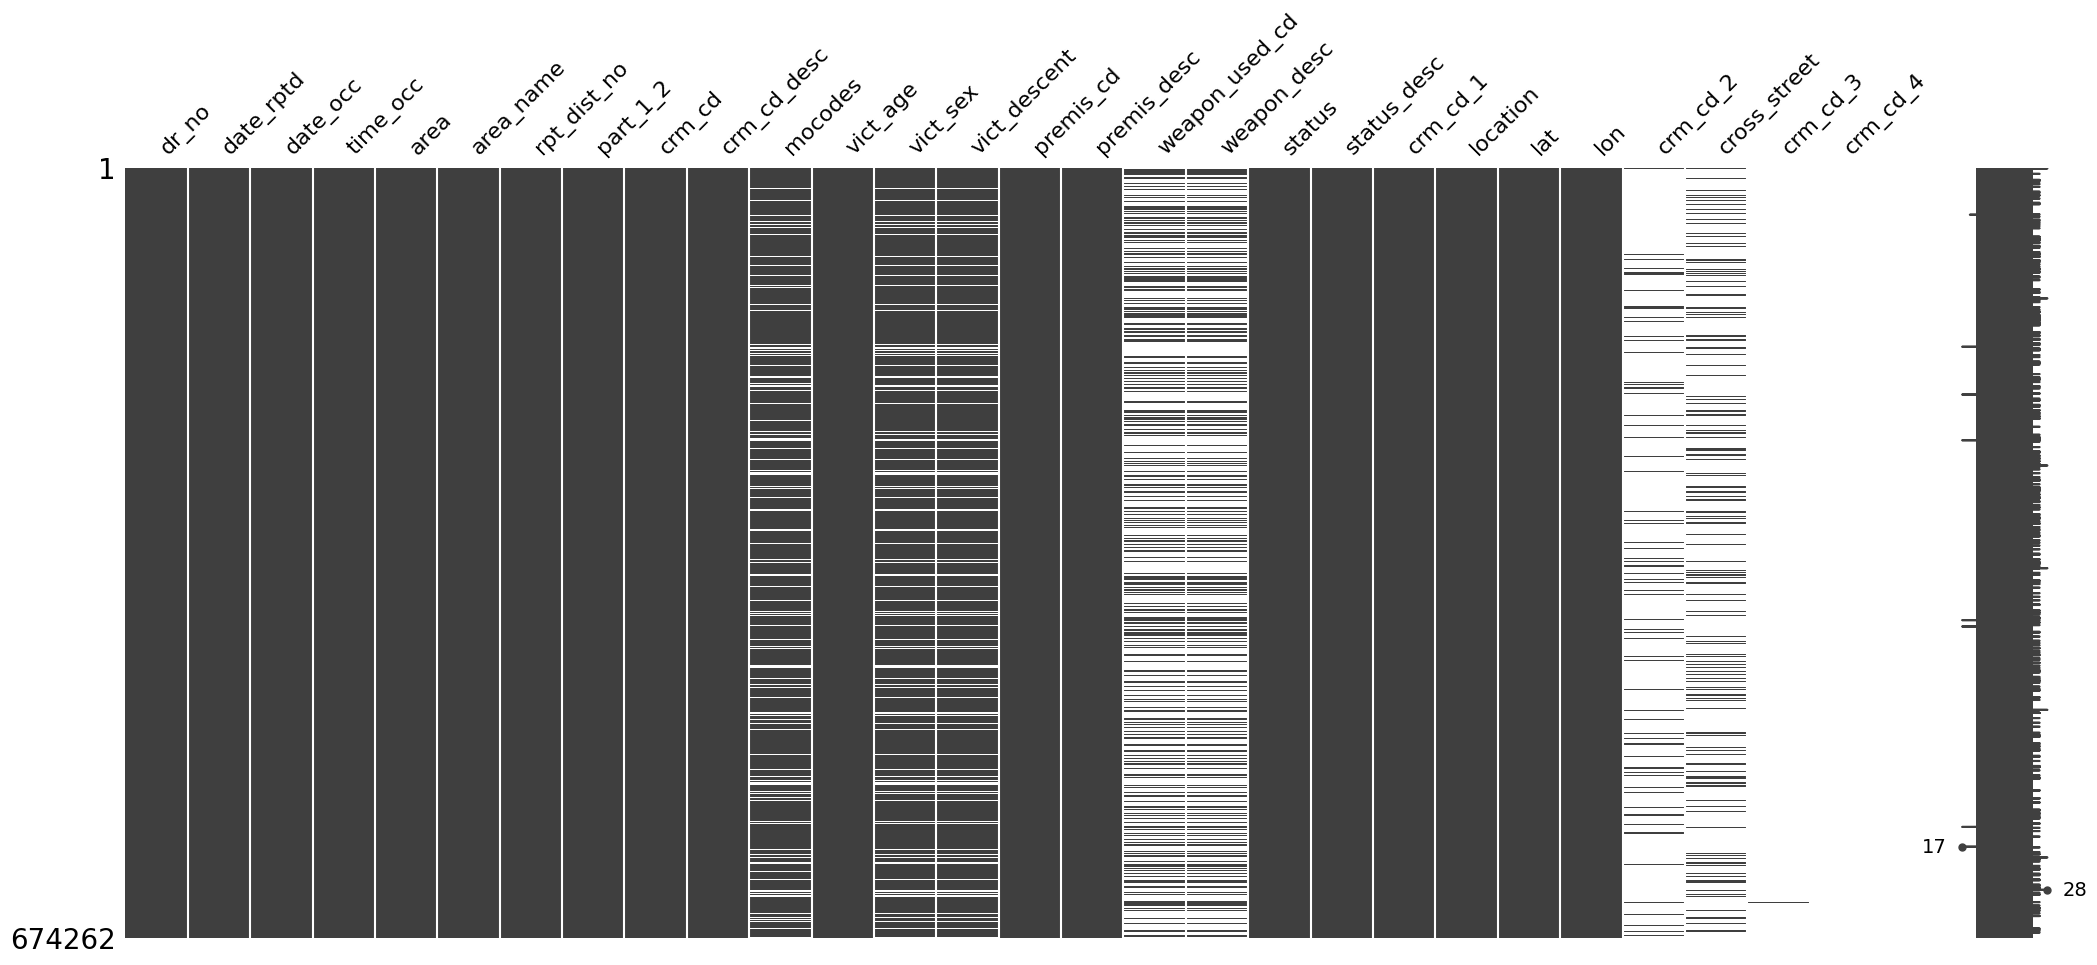

In [91]:
msno.matrix(data)

<Axes: >

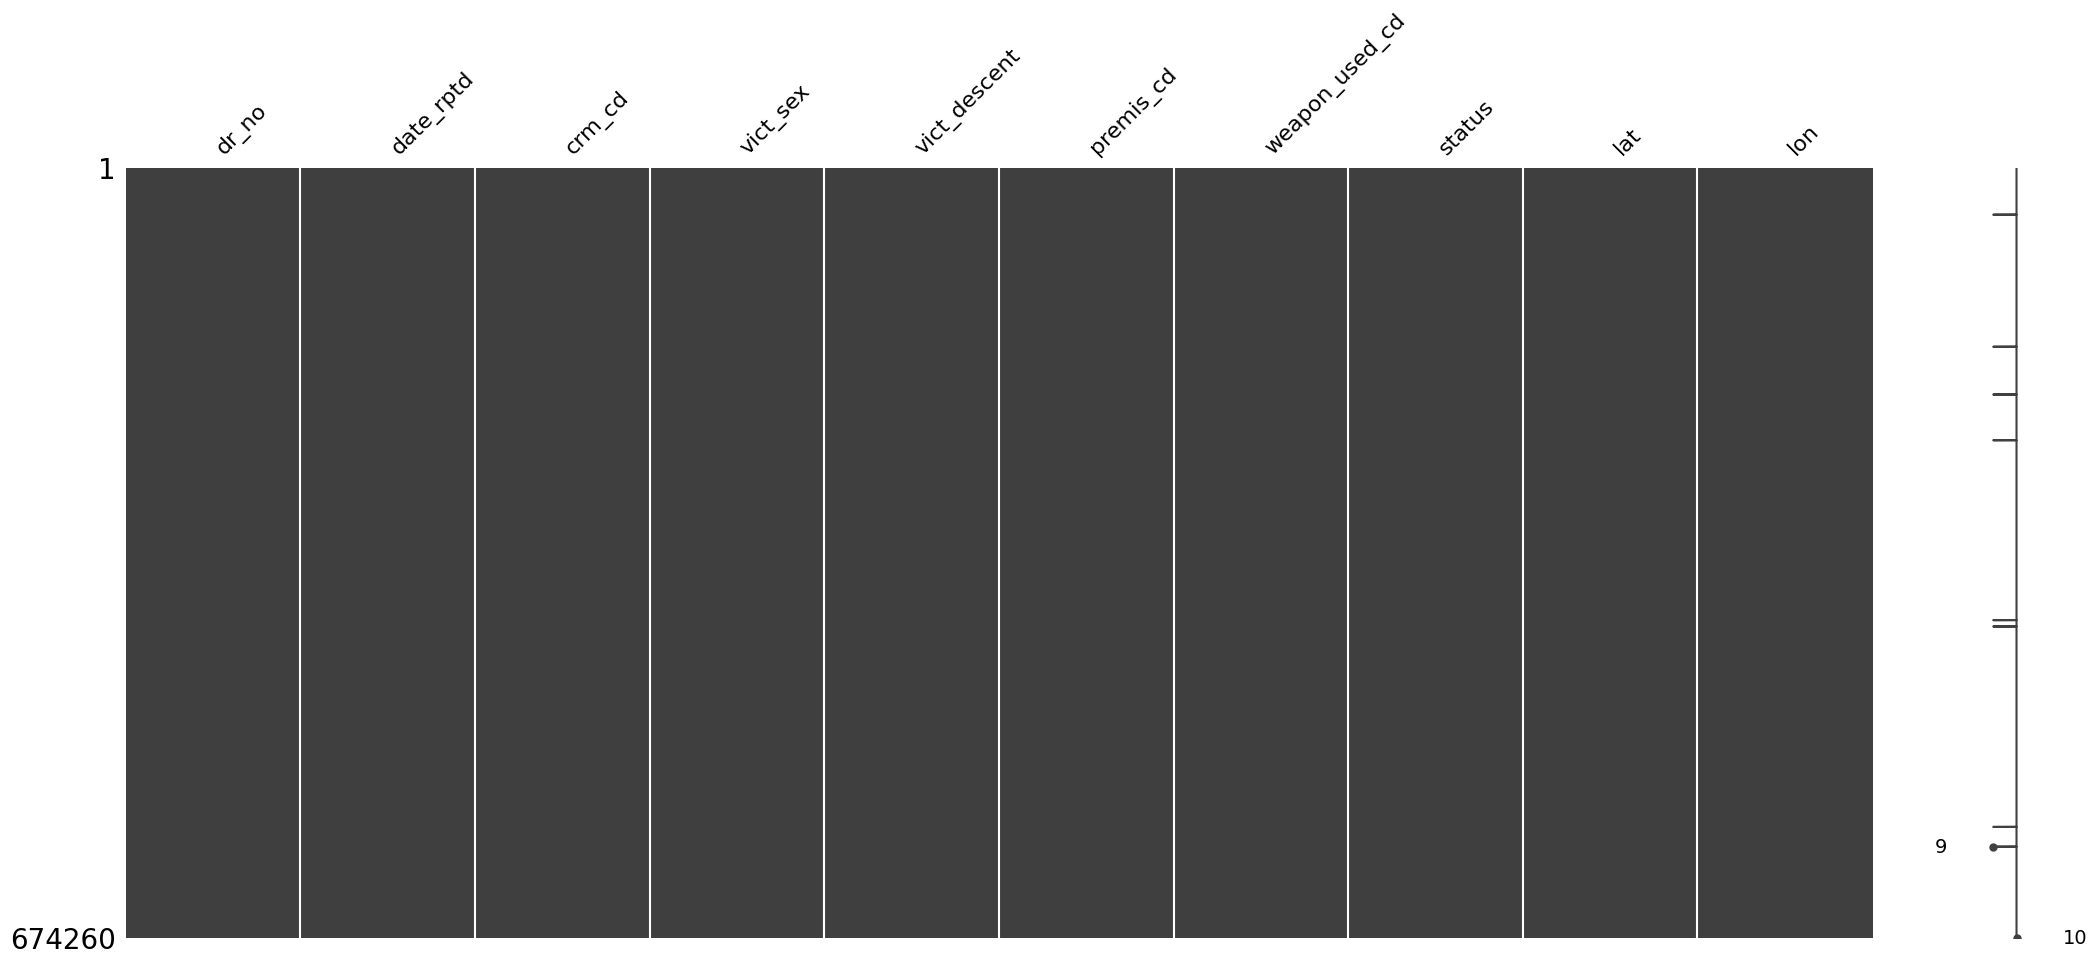

In [92]:
msno.matrix(cleaner.df)

### Clipping

In [93]:
cleaner.clipping()

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'date_occ'}>],
       [<Axes: title={'center': 'time_occ'}>,
        <Axes: title={'center': 'vict_age'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>]],
      dtype=object)

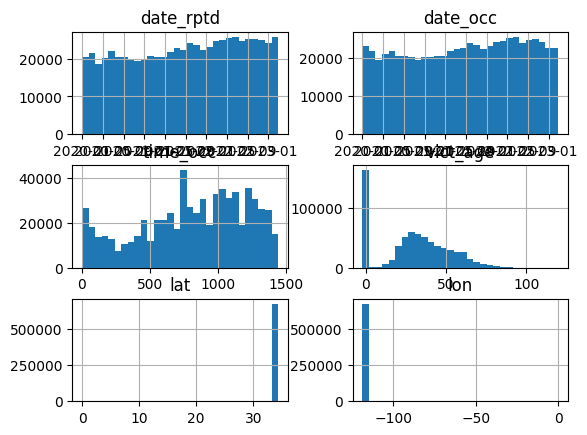

In [94]:
data.hist(bins=30)

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lon'}>, <Axes: >]], dtype=object)

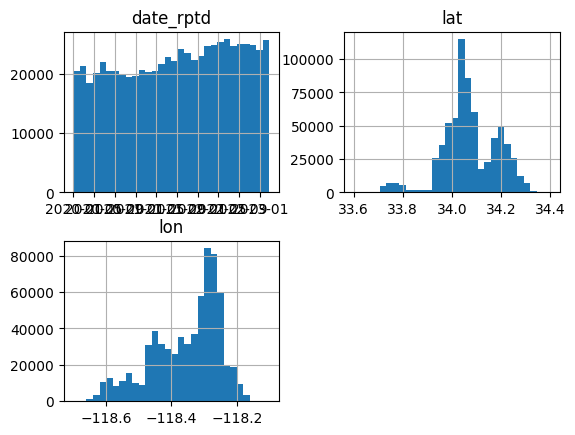

In [95]:
cleaner.df.hist(bins=30)

### Imputación

In [96]:
cleaner.simple_imp()

In [97]:
cleaner.df.isna().mean()

dr_no             0.0
date_rptd         0.0
crm_cd            0.0
vict_sex          0.0
vict_descent      0.0
premis_cd         0.0
weapon_used_cd    0.0
status            0.0
lat               0.0
lon               0.0
dtype: float64

### Lugar

In [98]:
cleaner.lugar()

<Axes: xlabel='premis_cd', ylabel='count'>

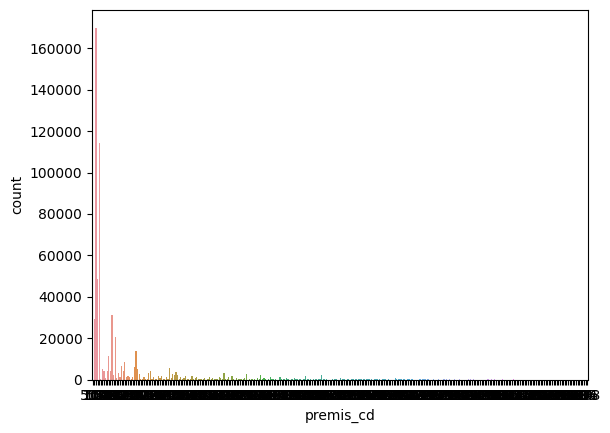

In [99]:
sns.countplot(data, x="premis_cd")

<module 'matplotlib.pyplot' from '/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/matplotlib/pyplot.py'>

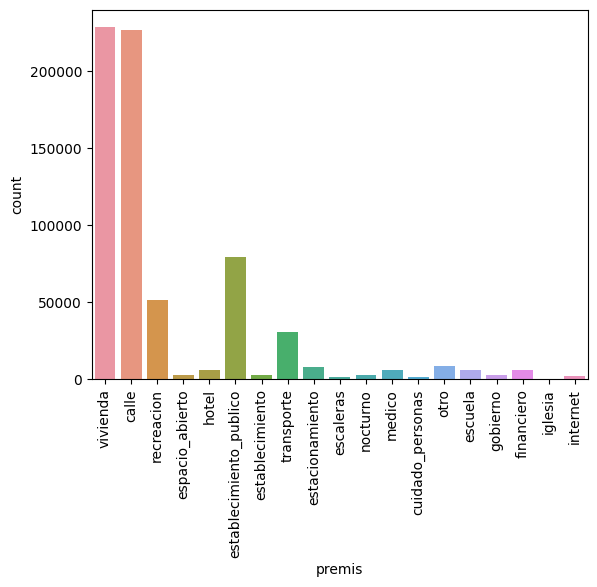

In [100]:
g=sns.countplot(cleaner.df,x="premis")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt

### Zonas

In [101]:
cleaner.zonas()

In [102]:
cleaner.df["zonas"].value_counts()/len(cleaner.df)

0    0.485568
3    0.180783
1    0.177670
2    0.111779
4    0.044200
Name: zonas, dtype: float64

### Categoricas

In [103]:
cleaner.categorias()

In [104]:
cleaner.df["premis"].value_counts()/len(cleaner.df)

vivienda                   0.339117
calle                      0.335959
establecimiento_publico    0.118020
Others                     0.085463
recreacion                 0.076282
transporte                 0.045159
Name: premis, dtype: float64

### Super clases

In [105]:
cleaner.super_clases()

In [106]:
cleaner.df.tail()

,dr_no,date_rptd,vict_sex,vict_descent,premis_cd,weapon_used_cd,status,lat,lon,premis,zonas,crime,crm_cd
674255,230707285,2023-02-27,X,X,203.0,0,IC,34.0436,-118.3248,establecimiento_publico,0,Robo,103
674256,230806533,2023-02-27,M,O,501.0,0,IC,34.0502,-118.4161,vivienda,3,Disturbios a la sociedad,101
674257,231605843,2023-02-27,F,W,502.0,0,IC,34.2275,-118.3664,vivienda,1,Falta a la ley,102
674258,231906365,2023-02-27,F,H,501.0,Others,IC,34.3235,-118.4260,vivienda,1,Agresión,100
674259,230606434,2023-02-27,M,H,502.0,Others,IC,34.1016,-118.3361,vivienda,3,Robo Vehículo,104


## Cubo

In [7]:
from datetime import datetime
from pandas import date_range, read_csv, DataFrame
from statsmodels.tsa.api import SimpleExpSmoothing

class CubeCrimesGenerator():
    
    def __init__(self,df):
        self.df = df.copy()
        data= self.df.copy()
        data["Date"]=data["date_rptd"]
        self.start= str(data["Date"].min())
        self.end= str(data["Date"].max())
        self.ls_dfs=[]
    
    def checkDates(self,data,zone,crimeType):
        data["Date"]=data["date_rptd"]
        date_index = date_range(start=self.start, end=self.end, freq="D")
        data = data.set_index("Date").reindex(date_index)
        data.drop(columns=["date_rptd"], inplace=True)
        field = "Crimes_Z"+str(zone)+"T"+str(crimeType)
        data.rename(columns={0: field}, inplace= True)
        data[field]= data[field].fillna(0)
        return data
    
    
    def generateDataframes(self):
        ls_dfs= []
        for zone in range(5):
            test = self.df[self.df['zonas']==zone].copy()
            for crime in range(100,105):
                test2 = test[test['crm_cd']==crime].copy()
                temp =test2.groupby('date_rptd').size().copy()
                temp= temp.to_frame()
                temp= temp.reset_index()
                data= self.checkDates(temp,zone,crime)
                self.ls_dfs.append(data)
                
    def generateCube(self):
        self.generateDataframes()
        df_final= self.ls_dfs[0]

        for i in range(1, len(self.ls_dfs)):
            column= self.ls_dfs[i].columns[0]
            df_final[column]= list(self.ls_dfs[i][column])
        df_final["week"]=df_final.index.to_period('W-SUN').start_time
            
        return df_final.groupby(by="week").sum()

In [108]:
cubo= CubeCrimesGenerator(cleaner.df)

In [109]:
df_cubo=cubo.generateCube()

In [110]:
len(df_cubo)

166

In [111]:
df_cubo.to_csv("cubo_sem.csv")

## Feature engineering

In [16]:
class FeatureEngineering():
    
    def __init__(self,df):
        self.df= df
        self.temp= DataFrame()
        
    def createLags(self,column):
        temp= self.df[[column]]
        for i in range(1,34):
            temp[column+"_"+str(i)] = temp[column].shift(i)
        self.temp=temp
    
    def smoothing(self, column):
        for i in range(2,10,1):
            j=i/10
            fit1 = SimpleExpSmoothing(self.temp[column], initialization_method="heuristic").fit(smoothing_level=j, optimized=False)
            lista=fit1.fittedvalues
            self.temp['exp'+str(j)]=lista
            
    def createMA(self,column):
        for i in range(2,11,2):
            self.temp["MA"+str(i)]= self.temp[column].rolling(window =i).mean()
    
   
    
    def createVariables(self,column):
        self.createLags(column)
        #self.smoothing(column)
        self.createMA(column)
        self.temp["Target"]= self.temp[column].shift(-1)
        self.temp.dropna(inplace=True)
        return self.temp

### Create lags

In [17]:
import pandas as pd

In [25]:
df_cubo=pd.read_csv("cubo_sem.csv")

In [26]:
df_cubo.rename(columns={'week':"date"}, inplace=True)

In [27]:
df_cubo.set_index('date', inplace=True)

In [28]:
feature= FeatureEngineering(df_cubo)

In [29]:
column="Crimes_Z4T100"

In [30]:
df_feature=feature.createVariables(column)

/tmp/ipykernel_3875/2562748499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[column+"_"+str(i)] = temp[column].shift(i)
/tmp/ipykernel_3875/2562748499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[column+"_"+str(i)] = temp[column].shift(i)
/tmp/ipykernel_3875/2562748499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [31]:
df_feature.to_csv("Feature.csv")

In [30]:
feature.createLags(column)

In [31]:
feature.temp.head()

,Crimes_Z4T100,Crimes_Z4T100_1,Crimes_Z4T100_2,Crimes_Z4T100_3,Crimes_Z4T100_4,Crimes_Z4T100_5,Crimes_Z4T100_6,Crimes_Z4T100_7,Crimes_Z4T100_8,Crimes_Z4T100_9,...,Crimes_Z4T100_24,Crimes_Z4T100_25,Crimes_Z4T100_26,Crimes_Z4T100_27,Crimes_Z4T100_28,Crimes_Z4T100_29,Crimes_Z4T100_30,Crimes_Z4T100_31,Crimes_Z4T100_32,Crimes_Z4T100_33
date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-20,34.0,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,32.0,34.0,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Smothing

In [16]:
feature.smoothing(column)

/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:47

In [17]:
feature.temp.head()

,Crimes_Z4T100,Crimes_Z4T100_1,Crimes_Z4T100_2,Crimes_Z4T100_3,Crimes_Z4T100_4,Crimes_Z4T100_5,Crimes_Z4T100_6,Crimes_Z4T100_7,Crimes_Z4T100_8,Crimes_Z4T100_9,...,Crimes_Z4T100_32,Crimes_Z4T100_33,exp0.2,exp0.3,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9
date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.20000,28.20000,28.20000,28.2000,28.20000,28.20000,28.20000,28.20000
2020-01-06,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.56000,28.74000,28.92000,29.1000,29.28000,29.46000,29.64000,29.82000
2020-01-13,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.04800,29.41800,29.75200,30.0500,30.31200,30.53800,30.72800,30.88200
2020-01-20,34.0,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.03840,30.79260,31.45120,32.0250,32.52480,32.96140,33.34560,33.68820
2020-01-27,32.0,34.0,34.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.83072,31.75482,32.47072,33.0125,33.40992,33.68842,33.86912,33.96882


### Create MA

In [18]:
feature.createMA(column)

In [19]:
feature.temp.tail()

,Crimes_Z4T100,Crimes_Z4T100_1,Crimes_Z4T100_2,Crimes_Z4T100_3,Crimes_Z4T100_4,Crimes_Z4T100_5,Crimes_Z4T100_6,Crimes_Z4T100_7,Crimes_Z4T100_8,Crimes_Z4T100_9,...,exp0.2,exp0.3,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA5,MA10
date,,,,,,,,,,,,,,,,,,,,,
2022-01-24,49.0,50.0,36.0,33.0,37.0,23.0,29.0,40.0,46.0,43.0,...,38.980269,39.340409,40.647100,42.263895,43.931055,45.548240,47.092291,48.572672,41.0,38.6
2022-01-31,53.0,49.0,50.0,36.0,33.0,37.0,23.0,29.0,40.0,46.0,...,40.984215,42.238286,43.988260,45.631947,46.972422,47.964472,48.618458,48.957267,44.2,39.6
2022-02-07,69.0,53.0,49.0,50.0,36.0,33.0,37.0,23.0,29.0,40.0,...,43.387372,45.466800,47.592956,49.315974,50.588969,51.489342,52.123692,52.595727,51.4,41.9
2022-02-14,41.0,69.0,53.0,49.0,50.0,36.0,33.0,37.0,23.0,29.0,...,48.509898,52.526760,56.155774,59.157987,61.635587,63.746802,65.624738,67.359573,52.4,42.0
2022-02-21,38.0,41.0,69.0,53.0,49.0,50.0,36.0,33.0,37.0,23.0,...,47.007918,49.068732,50.093464,50.078993,49.254235,47.824041,45.924948,43.635957,50.0,42.9


In [20]:
feature.temp.dropna(inplace=True)

In [21]:
feature.temp.head()

,Crimes_Z4T100,Crimes_Z4T100_1,Crimes_Z4T100_2,Crimes_Z4T100_3,Crimes_Z4T100_4,Crimes_Z4T100_5,Crimes_Z4T100_6,Crimes_Z4T100_7,Crimes_Z4T100_8,Crimes_Z4T100_9,...,exp0.2,exp0.3,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA5,MA10
date,,,,,,,,,,,,,,,,,,,,,
2020-08-17,60.0,53.0,44.0,41.0,49.0,72.0,49.0,55.0,41.0,35.0,...,48.133055,49.076630,49.299167,49.446025,49.785524,50.377546,51.173636,52.080075,49.4,49.9
2020-08-24,42.0,60.0,53.0,44.0,41.0,49.0,72.0,49.0,55.0,41.0,...,50.506444,52.353641,53.579500,54.723012,55.914209,57.113264,58.234727,59.208007,48.0,50.6
2020-08-31,50.0,42.0,60.0,53.0,44.0,41.0,49.0,72.0,49.0,55.0,...,48.805155,49.247549,48.947700,48.361506,47.565684,46.533979,45.246945,43.720801,49.8,51.5
2020-09-07,44.0,50.0,42.0,60.0,53.0,44.0,41.0,49.0,72.0,49.0,...,49.044124,49.473284,49.368620,49.180753,49.026274,48.960194,49.049389,49.372080,49.8,50.4
2020-09-14,58.0,44.0,50.0,42.0,60.0,53.0,44.0,41.0,49.0,72.0,...,48.035299,47.831299,47.221172,46.590377,46.010509,45.488058,45.009878,44.537208,50.8,51.3


In [22]:
df_cubo.to_csv("features.csv")

### New models

## Predictions

In [ ]:
class Predictions():
    def __init__(self,df):
        self.df= df
        self.star= df["date"].max()
        self.end= ( datetime.strptime(self.start, '%Y-%m-%d') + timedelta(days=7)).strftime('%Y-%m-%d')
        date_index = date_range(start=start, end=end, freq="D")
        self.temp= pd.DataFrame(columns=self.df.columns[1:], index=date_index)
        
    def scalerData(self,column,sc,sc2):
        X,y=self.temp.drop([column],axis=1).to_numpy(),self.temp[[column]].to_numpy(),

        X=sc.transform(X)
        y=sc2.transform(y)


        X= X.reshape(X.shape[0], 1, X.shape[1])
        return X, y

In [47]:
feature.temp.to_csv("Feature.csv")

In [143]:
df_feature= pd.read_csv("Feature.csv")

In [120]:
with open("models/FeatureEngineer/LSTM/model_100_4.pkl", "rb") as m:
    model = pickle.load(m)

2023-05-05 13:21:12.261558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 13:21:12.263407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 13:21:12.264812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [132]:
X.shape

(75, 1, 45)

In [139]:
a=X[-1].reshape((1,1,45))

In [140]:
predictions= sc2.inverse_transform(model.predict(a))

1/1 [==============================] - 0s 22ms/step


In [141]:
predictions

array([[12.92631]], dtype=float32)

In [192]:
test=pd.DataFrame(columns=df_feature.columns[1:], index=date_index)

In [196]:
test.iloc[:,-12:-4]=df_feature.iloc[-7:,-12:-4]

In [198]:
df_feature

,date,Crimes_Z3T100,Crimes_Z3T100_1,Crimes_Z3T100_2,Crimes_Z3T100_3,Crimes_Z3T100_4,Crimes_Z3T100_5,Crimes_Z3T100_6,Crimes_Z3T100_7,Crimes_Z3T100_8,...,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA10,MA20,MA30,MA40
0,2023-02-16,24,19.0,14.0,18.0,17.0,12.0,10.0,18.0,10.0,...,16.694824,17.093156,17.452642,17.792305,18.143794,18.538487,16.3,16.60,16.633333,15.925
1,2023-02-17,6,24.0,19.0,14.0,18.0,17.0,12.0,10.0,18.0,...,19.616894,20.546578,21.381057,22.137691,22.828759,23.453849,14.8,16.20,16.166667,15.600
2,2023-02-18,21,6.0,24.0,19.0,14.0,18.0,17.0,12.0,10.0,...,14.170137,13.273289,12.152423,10.841307,9.365752,7.745385,15.9,16.45,16.300000,15.725
3,2023-02-19,13,21.0,6.0,24.0,19.0,14.0,18.0,17.0,12.0,...,16.902082,17.136645,17.460969,17.952392,18.673150,19.674538,15.4,15.65,16.100000,15.725
4,2023-02-20,21,13.0,21.0,6.0,24.0,19.0,14.0,18.0,17.0,...,15.341249,15.068322,14.784388,14.485718,14.134630,13.667454,16.5,16.05,16.133333,15.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2023-04-27,11,26.0,7.0,24.0,13.0,9.0,14.0,11.0,13.0,...,18.163071,19.257769,20.356982,21.511098,22.787036,24.258647,14.1,13.55,13.966667,13.750
71,2023-04-28,13,11.0,26.0,7.0,24.0,13.0,9.0,14.0,11.0,...,15.297843,15.128885,14.742793,14.153329,13.357407,12.325865,14.1,13.40,14.000000,13.800
72,2023-04-29,25,13.0,11.0,26.0,7.0,24.0,13.0,9.0,14.0,...,14.378706,14.064442,13.697117,13.345999,13.071481,12.932586,15.3,14.00,14.233333,14.050
73,2023-04-30,19,25.0,13.0,11.0,26.0,7.0,24.0,13.0,9.0,...,18.627223,19.532221,20.478847,21.503800,22.614296,23.793259,16.1,14.75,14.366667,14.300


In [201]:
test.iloc[:]

,Crimes_Z3T100,Crimes_Z3T100_1,Crimes_Z3T100_2,Crimes_Z3T100_3,Crimes_Z3T100_4,Crimes_Z3T100_5,Crimes_Z3T100_6,Crimes_Z3T100_7,Crimes_Z3T100_8,Crimes_Z3T100_9,...,exp0.4,exp0.5,exp0.6,exp0.7,exp0.8,exp0.9,MA10,MA20,MA30,MA40
2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.89742,18.031077,19.23114,20.456644,21.675906,22.864721,NaN,NaN,NaN,NaN
2023-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.938452,12.515539,11.892456,11.036993,9.935181,8.586472,NaN,NaN,NaN,NaN
2023-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.163071,19.257769,20.356982,21.511098,22.787036,24.258647,NaN,NaN,NaN,NaN
2023-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.297843,15.128885,14.742793,14.153329,13.357407,12.325865,NaN,NaN,NaN,NaN
2023-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.378706,14.064442,13.697117,13.345999,13.071481,12.932586,NaN,NaN,NaN,NaN
2023-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.627223,19.532221,20.478847,21.5038,22.614296,23.793259,NaN,NaN,NaN,NaN
2023-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.776334,19.266111,19.591539,19.75114,19.722859,19.479326,NaN,NaN,NaN,NaN


In [200]:
df_feature.iloc[:,2]

0     19.0
1     24.0
2      6.0
3     21.0
4     13.0
      ... 
70    26.0
71    11.0
72    13.0
73    25.0
74    19.0
Name: Crimes_Z3T100_1, Length: 75, dtype: float64